# Clothes Classification

## Import packages

In [18]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from os.path import exists
from random import randint
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from tqdm import tqdm

In [4]:
tqdm.pandas()

c:\users\errry\pycharmprojects\clothesclassification\venv\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Explore data
The following dataset was made by Zalando Data Science team, and it is fully described [here](https://arxiv.org/pdf/1708.07747.pdf).

It contains preprocessed clothes photos, in format of 28 x 28 matrices in grayscale (0 to 255).

There are 10 labels in dataset:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [6]:
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Training set checkout

In [7]:
tr_set = pd.read_csv("data/fashion-mnist_train.csv")

In [5]:
tr_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

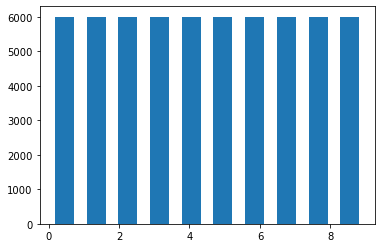

In [6]:
plt.hist(tr_set['label'], rwidth=0.6)

So we can see that the training data is equally composed.

Let's try to look at random sample:

In [7]:
def show_sample(sample_id, dataset):
    sample = dataset.iloc[[sample_id]]
    label = int(sample['label'])
    img = np.array(sample, dtype='float')
    img = img[:, 1:]
    img = img.reshape((28,28))

    plt.imshow(img, cmap='gray')
    plt.title("Label {0}: {1} - sample {2}".format(label, label_names[label], sample_id))
    plt.show()

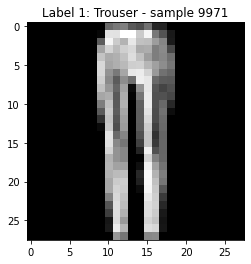

In [8]:
show_sample(randint(0,60000), tr_set)

### Test set checkout
We can also check composition of test set:

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

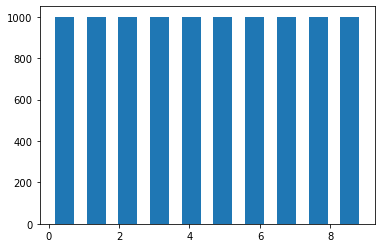

In [8]:
tst_set = pd.read_csv('data/fashion-mnist_test.csv')
plt.hist(tst_set['label'], rwidth=0.6)

And it is also well composed like training set - each label has 1000 samples.

### Labels differences
We will check full dataset - both train and test data. Also, I will add `label_name` column to make comparision more clearly

In [10]:
full_set = pd.concat([tr_set, tst_set])
full_set['label_name'] = pd.DataFrame([label_names[el] for el in list(full_set.iloc[:, 0].astype(int))])

#### Composition of white pixels
Now we can try to spot differences between each clothes types. For example, sandals have much less white pixels than ankle boots. Let's see comparision of classes.

In [11]:
full_set['pixels_sum'] = full_set.iloc[:, 1:-1].sum(axis=1)
labels_pixels_sum = full_set.groupby(by=['label_name'])['pixels_sum'].mean()

In [12]:
labels_pixels_sum

label_name
Ankle boot     59999.078596
Bag            68809.013192
Coat           74199.152601
Dress          52686.620793
Pullover       72672.227881
Sandal         31586.809789
Shirt          65265.959271
Sneaker        37018.868552
T-shirt/top    63927.906977
Trouser        46298.467298
Name: pixels_sum, dtype: float64

<AxesSubplot:title={'center':'Pixels sum'}, xlabel='label_name'>

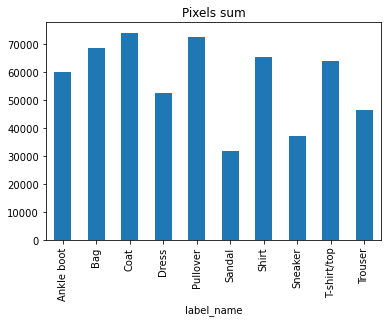

In [13]:
labels_pixels_sum.plot.bar(title="Pixels sum")

As we can see above, the labels have different mean of `pixels_sum`. *Coat* by average has the most white pixels, whereas *sandal* has the least.

#### White pixels symetry
Another difference between clothes, may be their symetry. *Trouser* are definitely symmetrical, while *boot* is not. Let's create `symmetrical` parameter and calculate it for each sample.

In [11]:
def calc_symmetry(pixels, tolerance):
    '''
    @param: pixels - one dim list of pixels, from 0 to 784
    @param: tolerance - how big the difference between mirror pixels can be
    
    @return: symmetry coefficient - amount of symmetrical pairs by total amount of pairs (392)
    '''
    
    sym_pairs = 0
    
    for i in range(0, 784, 28):
        for j in range(0, 14):
            if abs(pixels[i+j] - pixels[i+27-j]) < tolerance:
                sym_pairs += 1
                
    return sym_pairs/392
        

In [15]:
full_set['symmetrical'] = full_set.progress_apply(lambda row: calc_symmetry(list(row.iloc[1:785]), tolerance=5), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:33<00:00, 2061.46it/s]


In [16]:
labels_avg_symmetry = full_set.groupby(by=['label_name'])['symmetrical'].mean()
labels_avg_symmetry

label_name
Ankle boot     0.393831
Bag            0.519711
Coat           0.523213
Dress          0.638159
Pullover       0.533227
Sandal         0.598874
Shirt          0.507692
Sneaker        0.618731
T-shirt/top    0.573640
Trouser        0.647046
Name: symmetrical, dtype: float64

<AxesSubplot:title={'center':'Symmetry'}, xlabel='label_name'>

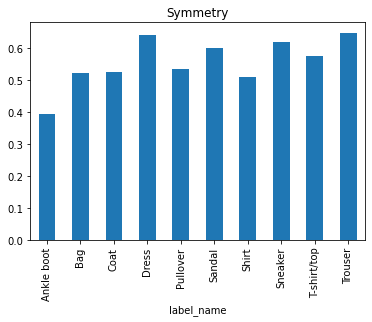

In [17]:
labels_avg_symmetry.plot.bar(title="Symmetry")

For `tolerance` equals 5 points of grayscale, it can be observed that *Ankle boot* is less symmetrical than other clothes. There is group of clothes with symmetry about 50% - *bag, coat, pullover* and *shirt*. The most symmetrical are *dress* and *trouser*.

#### Combine both 'Pixels sum' and 'Symmetrical'
From both histograms we can notice some differences between classes, let's see scatter plot based on `pixels_sum` and `symmetrical`.

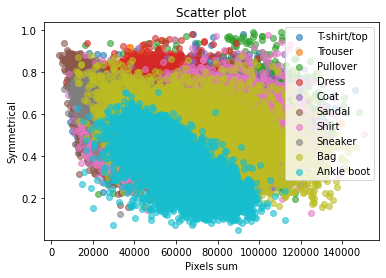

In [18]:
for lbl in range(10):
    tmp = full_set[full_set.label.eq(lbl)]
    x, y = tmp['pixels_sum'], tmp['symmetrical']
    plt.scatter(x, y, alpha=0.6, label=label_names[lbl])

plt.title("Scatter plot")
plt.xlabel("Pixels sum")
plt.ylabel("Symmetrical")
plt.legend(loc="upper right")


plt.show()

Unfortunatelly, we have too many classes (10), and also too many samples (70 000), to see every dependency on scatter plot. But we can see that *ankle boot* has a litlle `symmetrical` and `pixels_sum` value, whereas *pullover* is on the opposite site of the plot.

## Predicting

The problem that we have to deal with is classification of 10 clothes labels. The models we will try are: 

1. Logistic Regression
2. K-Neighbours
3. Support Vector Machines
4. Decision Trees
5. Random Forest
6. Neural Networks


### 1. Logistic Regression

The first model will be the simplest, as the point of reference to the other models. 

#### Two params
Let's try to use factors made during data exploration: `pixels_sum` and `symmetrical`

In [12]:
tr_set['pixels_sum'] = tr_set.iloc[:, 1:-1].sum(axis=1)
tr_set['symmetrical'] = tr_set.progress_apply(lambda row: calc_symmetry(list(row.iloc[1:785]), tolerance=5), axis=1)
tr_set['label_name'] = pd.DataFrame([label_names[el] for el in list(full_set.iloc[:, 0].astype(int))])

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:27<00:00, 2220.80it/s]


NameError: name 'full_set' is not defined

In [ ]:
tst_set['pixels_sum'] = tst_set.iloc[:, 1:-1].sum(axis=1)
tst_set['symmetrical'] = tst_set.progress_apply(lambda row: calc_symmetry(list(row.iloc[1:785]), tolerance=5), axis=1)
tst_set['label_name'] = pd.DataFrame([label_names[el] for el in list(full_set.iloc[:, 0].astype(int))])

Fit logitstic regression classifier with mentioned two parameters:

In [21]:
log_mdl = LogisticRegression(verbose=True)

If model was trained before we can just load it from file. This flow would be useful in other models, so we can create appropriate function:

In [15]:
def fit_or_load(model, filename, X, y):
    if exists(filename):
        model = pickle.load(open(filename, 'rb'))
    else:
        model.fit(X, y)
        pickle.dump(model, open(filename, 'wb'))
    return model

In [23]:
log_mdl = fit_or_load(log_mdl, 'models/log_mdl2params.sav', tr_set.iloc[:, -3:-1], tr_set.iloc[:, 0])

In [24]:
log_mdl.predict(tst_set.iloc[:, -3:-1])

array([4, 4, 4, ..., 4, 4, 4], dtype=int64)

In [25]:
log_mdl.score(tst_set.iloc[:, -3:-1], tst_set.iloc[:, 0])

0.1

It looks like model fit only to one label. 

#### All 784 features
Let's look how it works for original dataset features - from 1 to 784. That's really big amount of features, but we can try. As we have more factors to use, we will try more powerful `solver`, and increase `max_iter` to 10 000.

In [26]:
log_mdl2 = LogisticRegression(verbose=True, solver='sag', max_iter=10000)

In [27]:
log_mdl2 = fit_or_load(log_mdl2, 'models/log_mdl.sav', tr_set.iloc[:, 1:785], tr_set.iloc[:, 0])

The following model was trained for about 4700 epochs

In [28]:
log_mdl2.predict(tst_set.iloc[:, 1:785])

array([0, 1, 2, ..., 8, 6, 2], dtype=int64)

In [29]:
log_mdl2.score(tst_set.iloc[:, 1:785], tst_set.iloc[:, 0])

0.8403

As we can see, even if we use 784 features, result on test data is quite impressive - over **84%**

In [30]:
log_mdl2.score(tr_set.iloc[:, 1:785], tr_set.iloc[:, 0])

0.8830166666666667

And there is only 4% difference between score on train and test set.

### 2. K-Neighbours

#### All 784 features
Many features can be really tough to calculate with this algorithm, but we can try:

In [55]:
nneighbors = KNeighborsClassifier(n_neighbors=3, leaf_size=5)

In [56]:
nneighbors = fit_or_load(nneighbors, "models/nneighbors.sav", tr_set.iloc[:, 1:785], tr_set.iloc[:, 0])

In [61]:
#nneighbors.score(tst_set.iloc[:, 1:785], tst_set.iloc[:, 0])

0.8584

`0.8584`

This model has about **86%** accuracy, which is quite better than logistic regression model.

As model created with 784 parameters data has about 900MB, it is to large to use on my machine. We can try 2 parameters data

#### Two params

In [37]:
nneighbors2 = KNeighborsClassifier(n_neighbors=3)

In [38]:
nneighbors2 = fit_or_load(nneighbors2, 'models/nneighbors2params.sav', tr_set.iloc[:, -3:-1], tr_set.iloc[:, 0])

In [40]:
nneighbors2.predict(tst_set.iloc[:, -3:-1])

array([0, 1, 0, ..., 0, 2, 0], dtype=int64)

In [41]:
nneighbors2.score(tst_set.iloc[:, -3:-1], tst_set.iloc[:, 0])

0.1878

Model feed with only 2 parameters has rather poor accuracy, but also better than logistic regression model with same data. 

We can try to test it for another `n_neighbors` values:

In [50]:
k_values = range(1, 21) # k = [1,2 .. 10]

In [51]:
k_scores = {}
for k in k_values:
    nneighbors2 = KNeighborsClassifier(n_neighbors=k)
    nneighbors2 = fit_or_load(nneighbors2, 'models/nneighbors2params_k{}.sav'.format(k), tr_set.iloc[:, -3:-1], tr_set.iloc[:, 0])    
    k_scores[k] = [nneighbors2.score(tr_set.iloc[:, -3:-1], tr_set.iloc[:, 0]),
                   nneighbors2.score(tst_set.iloc[:, -3:-1], tst_set.iloc[:, 0])]

In [52]:
k_scores

{1: [0.9984666666666666, 0.1899],
 2: [0.5956833333333333, 0.1814],
 3: [0.50415, 0.1878],
 4: [0.46921666666666667, 0.2013],
 5: [0.4452833333333333, 0.207],
 6: [0.4236, 0.208],
 7: [0.40455, 0.2133],
 8: [0.3912, 0.2193],
 9: [0.3804, 0.2205],
 10: [0.36943333333333334, 0.2278],
 11: [0.36375, 0.2327],
 12: [0.35845, 0.2318],
 13: [0.3534333333333333, 0.2295],
 14: [0.34868333333333335, 0.2308],
 15: [0.3438333333333333, 0.2316],
 16: [0.3395, 0.2355],
 17: [0.33726666666666666, 0.2369],
 18: [0.33386666666666664, 0.2358],
 19: [0.3310666666666667, 0.2392],
 20: [0.32705, 0.241]}

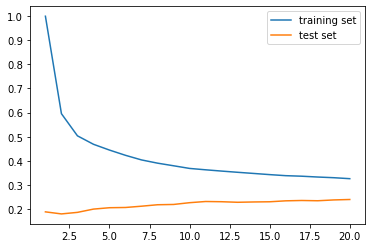

In [53]:
plt.plot(k_values, [k_scores[k][0] for k in k_scores], label="training set")
plt.plot(k_values, [k_scores[k][1] for k in k_scores], label="test set")
plt.legend()
plt.show()

As we can see from the curve, there is no way to fit K-Neighbors with only 2 params data.

When we increase parameter **k**, number of neighbours, then training accuracy decrease and test accuracy increase. But test accuracy grows really slow, whereas training score goes down fast. 

So, even if we fit data with the best `n_neighbors` value, we cannot expect good accuracy.

### 3. Support Vector Machine

Another option that we may consider is SVM model.

#### All 784 features

In [13]:
svc = SVC()

In [16]:
svc = fit_or_load(svc, "models/svc.sav", tr_set.iloc[:, 1:785], tr_set.iloc[:, 0])

As in previous model trained on whole 784 feature data, file with weights is large - now it's about 120MB. However, we can check out its accuracy:

In [17]:
svc.score(tst_set.iloc[:, 1:785], tst_set.iloc[:, 0])

0.8921

As we can see, default Support Vector Classifier achieved the highest accuracy for now. We can try also the `LinearSVC` model, which is recommended for large datasets.

In [19]:
lsvc = LinearSVC()

In [20]:
lsvc = fit_or_load(lsvc, "models/lsvc.sav", tr_set.iloc[:, 1:785], tr_set.iloc[:, 0])

c:\users\errry\pycharmprojects\clothesclassification\venv\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [21]:
lsvc.score(tst_set.iloc[:, 1:785], tst_set.iloc[:, 0])

0.7779

Linear SVM classifier is much more light, it require less than 1 MB, but, also has the weakest score.

#### Two parameters
To compare with other models, we can also learn default SVM on two parameter data.

In [23]:
svc2 = SVC()
svc2 = fit_or_load(svc2, "models/svc2.sav", tr_set.iloc[:, -3:-1], tr_set.iloc[:, 0])

In [24]:
svc2.score(tst_set.iloc[:, -3:-1], tst_set.iloc[:, 0])

0.1

In [25]:
svc2.predict(tst_set.iloc[:, -3:-1])

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

Here we can observe same situation as with 2 parameter logistic regression model, for each sample output is the same class. We have model which is totally underfitted.

### 4. Decision Tree
Now we can try model which may be first choice for every classification task - decision tree.